# Model-based Machine Learning (42186)

## Bayesian spatial count 

Katinka Klepsch (s174313), Malene Plauborg (s174301)

### Research topic

This project aims to model the youth pedestrian injuries in New York (2005-2014) through bayesian spatial count models. It will be investigated how non-linear dependencies can be introduced in the bayesian spatial count models and two different distribution; poisson and negative-binomial (NB) will be tested and compared to investigate which would result in the best performing model.

### Performance metrics
Following metrics will be used to evaluate the performance of the models and how good they are at predicting the number of accidents amongst the youth population.
* MSE based on the parameters estimated through sampling of the posterior from the generative process. Each model is sampled 1000 times.
* MSE based on parameters estimated through the mean posterior
* MSE based on parameters esimated through the median posterior


### Data
The data used for this project have been collected from the following data sources:
<br> https://data.mendeley.com/datasets/b5r4yztghx/2
<br> https://www.kaggle.com/code/muonneutrino/mapping-new-york-city-census-data/data

The data has been merged through the census tract id and imputed with median in those columns where data was missing. 


### Models
ALl models has been implemented while trying to investigate and find the best model to predict our target variable. The models are investigated, first using the assumption of a linear relationsship between X and our taget vairbale and after an assumption of a non-linear relationship between X and our target variable. The models investigated are based on two different starting point - regression models that assumes that the features are unrelated and hierarchical model that takes potential clusters of data into account. 


* Baseline model
 >The baseline is based on the assumption that there is a linear relation between the events. The baseline is implemented using a linear regression on the data and will serve as a benchmark when evaluating the performance of the other models.  

 $$y=\beta^Tx+\epsilon$$

 Where $\beta$ is a vector of coefficients and $\epsilon \sim N(0,\sigma^2)$ is an error term.


* Regression models
> Two bayesian regression models using NB and poisson distribution are build to investigate how well our model can perform exclustive using regression properties and linear assumptions and thereafter to compare when using a hierarchical structure. 
These models will be extended using a neural network to introduce a non-linear component in the bayesian spatial count models assuming that there are non-linar dependencies the data. The non-linear models will be extended through the inclusion of the hierarchical structure to test if the predictive power will be improved.

$$y_t \sim Poisson(y_t|exp(\alpha +\beta^T X_n))$$
NB?

Neural network
$$y_t \sim Poisson(y_t|exp(\alpha +X_n'\beta^T + f_{nnet}(X_n^*)))$$

* Bayesian hierachial models
>  In the regression models we have build models that our specifications assumes that all observations share a unique set of bia (alpha) correficietns (beta). This means that all observations are eqaully biased towards an accident independent of county - this is a quite strong assumption, and something we would like to investigate further in as from the exploratory analysis it was observed that some locations were more prone to accidents than others. This finding shows us that data may not be completely independing and there might be an underlying clustering in data, that can help us in our prediction. Using a hierachical model it is investigeated if we can naturally cluster data into some groups and thereby be able to predict more accurately and identify the factors contributing to accidents within the different areas. Bayesian Hierachical models are able to produce robust models with clustered data. As the data seemed to cluster dependent on county, this is investigated.  The shared global hyperpriors are contructed on our county feature in our data, that will allow the model to share individual probperties of the observations among a specific county. The hierarchical models build will be based on compromise between "no pooling" and "complete pooling" and each group gets its' own set of parameters.





The models developed are:
* Linear regression 
* Linear regression with feature selection
* Bayesian poisson regression
* Bayesian NB regression
* Neural network with bayesian poisson regression
* Neural network with NB bayesian regression
* Hierarchical model with poisson as posterior predictive
* Hierarchical model with NB as posterior predictive
* Hierachical model with poisson and NN component
* Hierachical model with NB and NN component

### Load packages

In [1]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch
import seaborn as sns
from pyro.infer import Predictive

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
import matplotlib
%matplotlib inline
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

##### Function to compute performance metrics and plots

Following section introduces the function applied in the analysis, in order to minimise the amount of repetitive code in the notebook

In [3]:
def compute_error(trues, predicted):
    """Fucntion to compute errors on ml model

    Args:
        trues (_type_): _description_
        predicted (_type_): _description_

    Returns:
        _type_: _description_
    """
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    mse = np.sum((predicted - trues)**2)/len(trues)
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, mse, r2

In [4]:
# Visualize predictions from the combined model and linear regression
def plot_predictions_comp(y_test,y_pred1,title1,y_pred2, title2):
    """plot to show predictions 

    Args:
        y_test (_type_): true y values
        y_pred1 (_type_): predictions for model
        title1 (_type_): title for first predicitons
        y_pred2 (_type_): predictions for model
        title2 (_type_): title for second prediction
    """
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    ax[0].plot(y_test, label="Targets")
    ax[0].plot(y_pred1, label=title1, alpha=0.85)
    ax[0].legend()
    ax[0].set_xlabel("Observations")

    ax[1].plot(y_test, label="Targets")
    ax[1].plot(y_pred2, label=title2, alpha=0.85)
    ax[1].legend()
    ax[1].set_xlabel("Observations")
    plt.show()

In [5]:
def plot_scatter(X_test,y_test,y_pred, title):
    """
    This function a scatter plot in order to compare target variable and predictions.
    """
    plt.plot(X_test[:,0], y_test, "rx")
    plt.plot(X_test[:,0], y_pred, 'bo')
    plt.legend(["true (noisy) data points", title])
    plt.show()

##### Load and prepare data for modelling
In this section the preprocessed data i loaded. The preprocessing has been handled in the exploratory notebook.

In [8]:
# Load data
df_all = pd.read_csv("data/data_merged.csv")  

In [7]:

 # Get input, output and groups by counties.
 def split_data(df, attributes,impute = False):
     """
     This functions splits data into training and test set. The function also splits our shared hyper prior variable (County) 
     in to training and test, as this is utilised in the hierarcicahl model. 

     """
    X = df[df.columns[~df.columns.isin(attributes)]] 
    
    # Handling missing data - impute data based on the median.
    if impute:
        X = X.fillna(X.median()).values
    
    # Target variable
    y = df["ped_injury_5to18"].values
    y_mean = y.mean()
    y_std = y.std()
    
    # factorizes counties from strings to numerical valuers
    cat_fact = df['County'].factorize()
    cat = cat_fact[0] # numerical values for counties
    cat_string = cat_fact[1] # string values for counties

    # predictive variable - number of individuals for each census tracts
    ind = df.values[:,1].astype("int")
    
    # split data into train and test using permutation
    train_perc = 0.80 # percentage of training data
    split_point = int(train_perc*len(y))
    perm = np.random.permutation(len(y))
    ix_train = perm[:split_point]
    ix_test = perm[split_point:]
    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    cat_train = cat[ix_train]
    cat_test = cat[ix_test]
    y_train = y[ix_train]
    y_test = y[ix_test]
    ind_train = ind[ix_train]
    ind_test = ind[ix_test]
    

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, cat_train.shape, cat_test.shape)
    
    return (X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string

In [9]:
# Attributes that are string - either make the dummy variables or remove them
string_att = list(df_all.columns[df_all.dtypes == object])
nominal = ['census_tract']
removed_attributes = nominal+string_att
removed_attributes.append("ped_injury_5to18")

# split target variables and variables into training and test data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string  = split_data(df_all, removed_attributes,True)

(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [10]:
# to have an overview of the features in out analysis the feature names are defined. 
feat_names = ['youth_pop_5to18',
       'commute_priv_vehicle', 'med_hhincome', 'avg_ann_daily_traffic',
       'fragment_index', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']

In [12]:
# Standardize input features only using X_train
X_train_std = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test_std = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
y_train_std = (y_train - y_mean) / y_std
y_test_std = (y_test - y_mean) / y_std

# Baseline model
In this section our baseline model is implemented using a liner regression 

 $$y=\beta^Tx+\epsilon$$

 Where $\beta$ is a vector of coefficients and $\epsilon ~N(0,\sigma^2)$ is an error term.

The model is based on our standardised set of both X and y using all 39 features

In [15]:
# make linear regression model
l_reg = linear_model.LinearRegression(fit_intercept=False)
l_reg.fit(X_train_std, y_train_std)

LinearRegression(fit_intercept=False)

In [158]:
# Make predictions for test set
ypred_lreg = l_reg.predict(X_test_std)

# Convert back to the original scale
ypred_lreg = ypred_lreg * y_std + y_mean
y_true = y_test_std * y_std + y_mean

print("first 5 predictions:", ypred_lreg[:5])
print("first 5 true values:", y_true[:5])

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, ypred_lreg)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

first 5 predictions: [12.40121493  4.46250607  7.26254474  7.88040123 18.63435962]
first 5 true values: [ 3.  2.  3.  9. 13.]
CorrCoef: 0.525
MAE: 4.572
RMSE: 6.404
MSE: 41.013
R2: 0.270


It can be seen than the prediction in our baseline is around 41 which gives room for improvement

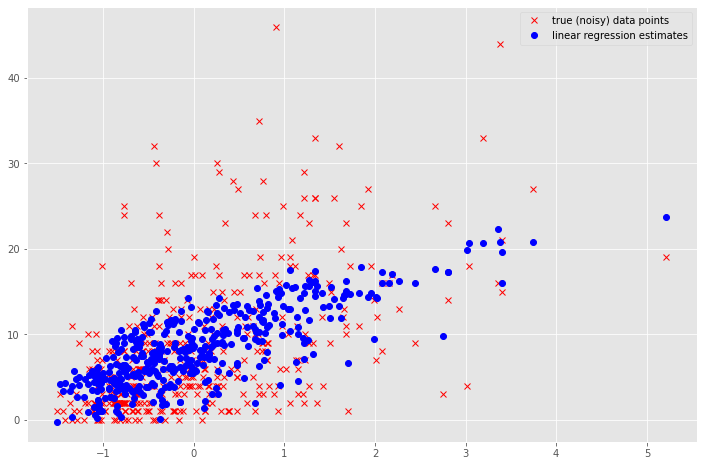

In [69]:
plot_scatter(X_test,y_test,ypred_lreg, "linear regression estimates")

The linear regression shows the estimates (the blue dots) compared to the true data points. It can be seen that there may be somewhat of linear tendensies.

## Feature selection
To reduce dimensionality a features selection is conducted as a high dimension in model usually contributed in a lot of noise. 
A feature selection can be made in many ways such as OLS, forward and backward selection. im this case the features is selected using an ordinary least square fit that shows how significant each of the features are to eachother. 

In [20]:
# Fit Ordinary Least Squares (OLS) model to the data.
X2 = sm.add_constant(X_train_std)
ols = sm.OLS(y_train_std, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     21.81
Date:                Tue, 24 May 2022   Prob (F-statistic):          1.02e-115
Time:                        10:41:42   Log-Likelihood:                -2042.5
No. Observations:                1676   AIC:                             4161.
Df Residuals:                    1638   BIC:                             4367.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.342e-14      0.020  -6.64e-13      1.0

From the OLS Regression Results we can see that many of the variables are statistically insignificant. 
<br> We will thus use Least Angle Regression to select the 8 most significant features.

In [21]:
lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train_std, y_train_std)
feature_ids = lars.coef_ != 0
feature_ids = np.array([i for i, incl in enumerate(feature_ids) if incl])
feature_ids_shifted = [0, *(feature_ids + 1)]
print("Features to be included:")
print("-"*20)
for idx in feature_ids:
    print(feat_names[idx])

Features to be included:
--------------------
youth_pop_5to18
commute_priv_vehicle
med_hhincome
White
Black
Poverty
Service
Transit


According the results the most significan features in regards to predicting accidents are the total youth population, commute private vehicle, income, race, powerty, service and transit. 
These features will be used in the ongoing model implementation, to ensure that all models are run on the same amount of data and to reduce potential noise.
To see how the OLS is after a feature selection the OLS is run again with the selected features.

In [22]:
# Fit new model with 8 most significant features
X2 = sm.add_constant(X_train_std[:, feature_ids])
ols2 = sm.OLS(y_train_std, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     96.63
Date:                Tue, 24 May 2022   Prob (F-statistic):          3.84e-132
Time:                        10:42:00   Log-Likelihood:                -2058.9
No. Observations:                1676   AIC:                             4136.
Df Residuals:                    1667   BIC:                             4185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.992e-17      0.020   1.48e-15      1.0

#### Linear regression with the selected features to evaluate performance
A linear regression is made with the feature selection to evaluate if the performance improves compared to the regression with all features. 

In [18]:
# Create and fit regression model only using chosen features
lreg = linear_model.LinearRegression()
lreg.fit(X_train_std[:, feature_ids], y_train_std)



# Make predictions for test set
y_pred_lreg_fs = lreg.predict(X_test_std[:, feature_ids])
print("First 5 predictions:", y_pred_lreg_fs[:5])
print("First 5 true values:", y_test_std[:5])

# Convert back to the original scale
y_pred_lreg_fs = y_pred_lreg_fs * y_std + y_mean
y_true = y_test_std * y_std + y_mean


# Evaluate prediction accuracy
corr, mae, rae, rmse, mse, r2 = compute_error(y_true, y_pred_lreg_fs)
print("\nPerformance metrics\nCorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

First 5 predictions: [-0.54800683  0.11149612 -0.53590865  0.47525999 -0.67838569]
First 5 true values: [-0.0219158   1.20244693 -1.11023823  2.69889027 -0.56607702]

Performance metrics
CorrCoef: 0.589
MAE: 4.640
RMSE: 6.345
MSE: 40.256
R2: 0.346


As can be seen, the linear regression with feature selection improve only slightly reducing to an MSE of 40.25 instead of 41.6.

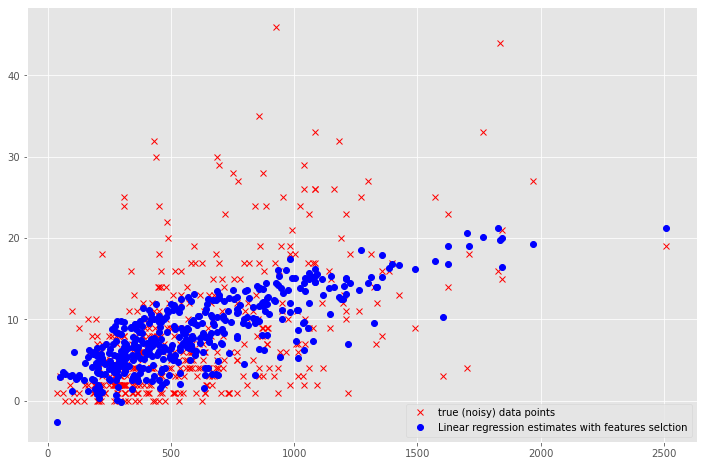

In [19]:
plot_scatter(X_test, y_test,y_pred_lreg_fs, "Linear regression estimates with features selction")

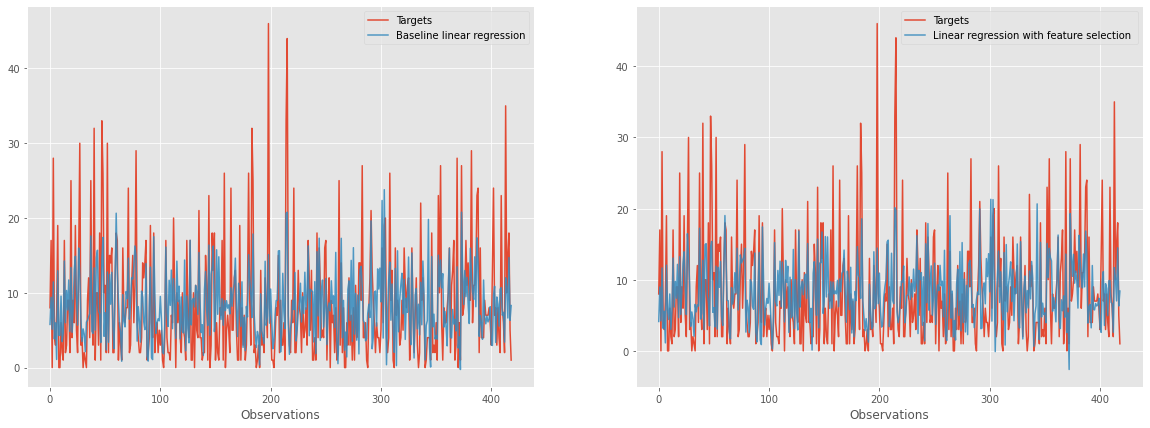

In [24]:
plot_predictions_comp(y_test,ypred_lreg,"Baseline linear regression", y_pred_lreg_fs,"Linear regression with feature selection ")

The visualisations indicates a small improvement when using the linear regression with the selected features, compared to the linear regression with all features included. It is also evident that a linear regression is not able to predict the target variable, and may not be the best model to do so. 

## Bayesian poisson regression
The poisson is a discrete distribition, that is often used to model count data. As our data is count data, that count the number of accidents at a given censustract, we were curios to see how the model would perform in a poisson regression model. This is also based on the exploratory analysis that shows that the target vairable does not follow a normal distirbution, but more like a poisson distribution with $\lambda = 1$

In this model it is assumed that the number of failures (accidents) follows a poisson distribution $X_i| \lambda ~P(\lambda_i)$ where $\lambda_i$ is the accident rate.

$$y_t \sim Poisson(y_t|exp(\alpha +\beta^T X_n))$$

The PGM can be seen below:

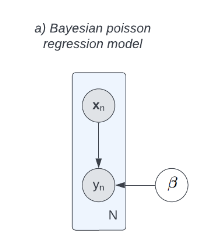

In [7]:
Image('Images/poisson.png')

The generative process can be seen below: 

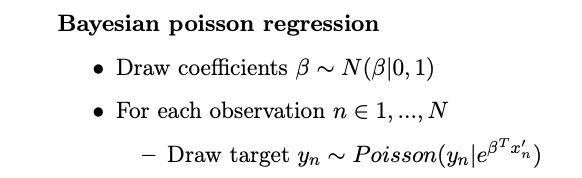

In [8]:
Image('Images/g_poisson.png')

In [ ]:
def poisson_model(X, obs=None):
    """Bayesian poisson model 

    Args:
        X (_type_): X train
        obs : y train

    Returns:
        _type_: predicitons
    """
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
    return y

Before we can use the model the data is preprocessed acording to the model specifications. We are using the standardised data for the X training set.

In [ ]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers
cat_test = torch.tensor(cat_test).long()

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  



Next step is to run the model, which is done with the code below. 

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 26229.3
[500] ELBO: 13476.6
[1000] ELBO: 7552.0
[1500] ELBO: 6567.7
[2000] ELBO: 6648.3
[2500] ELBO: 6349.4
[3000] ELBO: 6416.5
[3500] ELBO: 6431.7
[4000] ELBO: 6367.3
[4500] ELBO: 6377.9
[5000] ELBO: 6347.2
[5500] ELBO: 6374.9
[6000] ELBO: 6356.1
[6500] ELBO: 6334.6
[7000] ELBO: 6336.3
[7500] ELBO: 6331.7
[8000] ELBO: 6336.8
[8500] ELBO: 6339.3
[9000] ELBO: 6337.1
[9500] ELBO: 6340.9


After having processed the data, we can make predictions and extract the latent variables formthe posterior samples.
We are extracting
* beta
* alpha

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train_std_fs, y_train)

In [ ]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test_std_fs, beta_samples[:,0].T)), axis=1)

# convert back to the original scale
y_preds_poisson = y_hat # no need to do any conversion here because the Poisson model received untransformed y's
y_true = y_test

corr, mae, rae, rmse, mse, r2 = compute_error(y_true, y_preds_poisson)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.579
MAE: 4.682
RMSE: 6.397
MSE: 40.918
R2: 0.335


In [ ]:
# Make predictions for test set
predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("y", "_RETURN"))

samples = predictive(X_test_std_fs)
y_pred_nb = samples["y"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, mse, r2 = compute_error(y_true, y_pred_nb)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.578
MAE: 4.685
RMSE: 6.401
MSE: 40.979
R2: 0.334


As can be seen the model perform a lot like the baseline. 

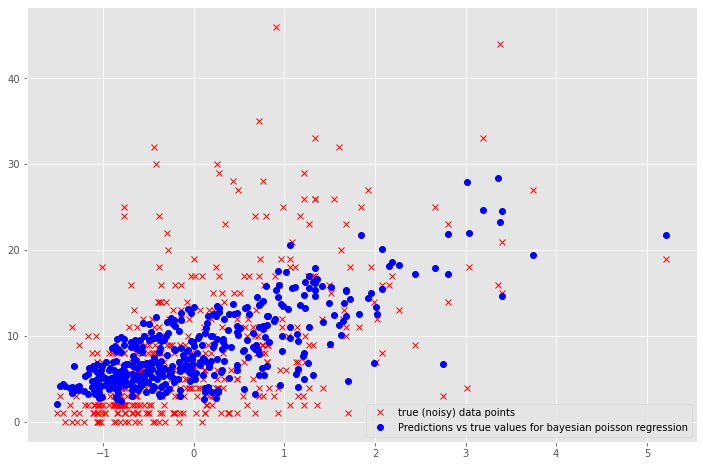

In [ ]:
plot_scatter(X_test,y_test,y_preds_poisson, "Predictions vs true values for bayesian poisson regression")

The figure above shows the true y values versus the predicted values. It can be seen that the predictions are not spot on, however they do capture some of the patterns

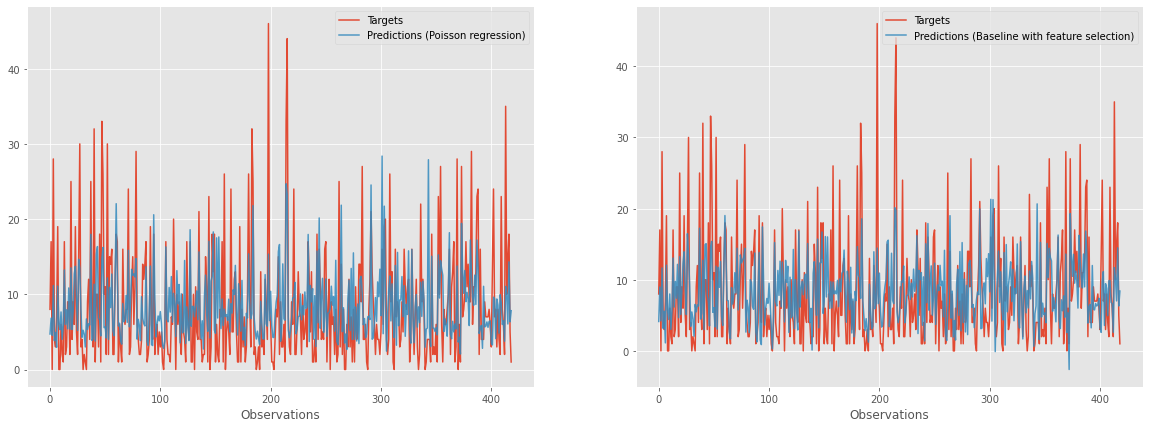

In [ ]:
# Visualize predictions from the hierarchical model and linear regression
plot_predictions_comp(y_test,y_preds_poisson,"Predictions (Poisson regression)",y_pred_lreg_fs, "Predictions (Baseline with feature selection)")


The figure above compares the poisson regression and the linear regression. Mostly it seems quite the same, however the poisson distribution do capture come higher values when the preidction has some higher values compared to the linear regression. 

## Bayesian negative binomial distribution

Next regression that could be interesting to investigate is the gamma distirbution with a negatve binomial distirbution as posterior. This could be interesting as when having a poisson likelihood it is recommended to use gamma as a conjungate priori and the negative binomial distribution as posterior. 

$$NB(x| \alpha', \frac{1}{1+\beta'})$$ 
where $\alpha$ is the total occurences in $\beta$ intervals.


Below the PGM can be seen

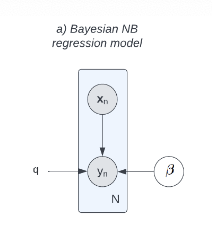

In [9]:
Image('Images/NB.png')

And the generative process can be seen below 

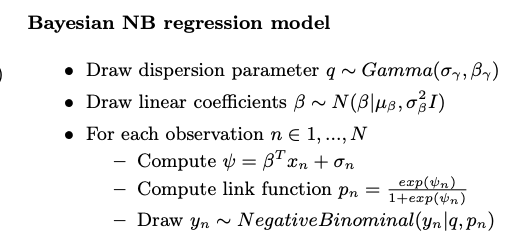

In [10]:
Image('Images/g_NB.png')

In [ ]:
def NB_model(X , obs=None):
    """Bayesian negative binomial model 

    Args:
        X (_type_): X train
        obs : y train

    Returns:
        _type_: predicitons
    """
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Draw parameters 
    alpha_gamma = 2
    beta_gamma = 6
    
    sigma_beta = 1
    mu_beta = 0
    
    # Draw priors
    # gamma distirbution
    q = pyro.sample("q", dist.Gamma(alpha_gamma, beta_gamma))
    #non-negative rate
    q = torch.exp(q)
        
    # Draw linear coefficient parameters for each level (no pooling)
    beta = pyro.sample(
        "beta",
            dist.Normal(mu_beta*torch.zeros(input_dim), 
                                        sigma_beta*torch.ones(input_dim)).to_event()) 
    sigma = pyro.sample(
        "sigma",
            dist.Normal(0*torch.zeros(input_dim), 
                                        1*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        # create link function         
        psi_mu = torch.sum(X*beta+sigma, axis=1)
        p_i = torch.exp(psi_mu)/(1+torch.exp(psi_mu))
        
        # Sample prediction using negative binomial on gamma prior as posterior predictive disitrbution (wiki)
        y = pyro.sample("y", dist.NegativeBinomial(q,probs=p_i), obs=obs) 
        
    return y

Next the data is preprocessed accordingly

In [ ]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  

And then the model is run

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(NB_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 37811.5
[500] ELBO: 11667.4
[1000] ELBO: 11254.7
[1500] ELBO: 11728.5
[2000] ELBO: 19932.5
[2500] ELBO: 18988.7
[3000] ELBO: 8568.8
[3500] ELBO: 6661.8
[4000] ELBO: 7084.9
[4500] ELBO: 17234.0
[5000] ELBO: 7264.7
[5500] ELBO: 8454.3
[6000] ELBO: 12792.3
[6500] ELBO: 11288.3
[7000] ELBO: 19327.3
[7500] ELBO: 7519.3
[8000] ELBO: 33762.2
[8500] ELBO: 11898.8
[9000] ELBO: 12023.2
[9500] ELBO: 10119.2


After having run the model we can extract the latent variables from the posterior distribution
* beta
* sigma

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("beta", "sigma"))
samples = predictive(X_train_std_fs, y_train)

In [ ]:
# Make predictions for test set
predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("y", "_RETURN"))

samples = predictive(X_test_std_fs)
y_pred_nb = samples["y"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, mse, r2 = compute_error(y_true, y_pred_nb)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.576
MAE: 7.203
RMSE: 9.155
MSE: 83.817
R2: 0.000


Unfortunately the model does not perform as well as expected compared to the poisson model. 

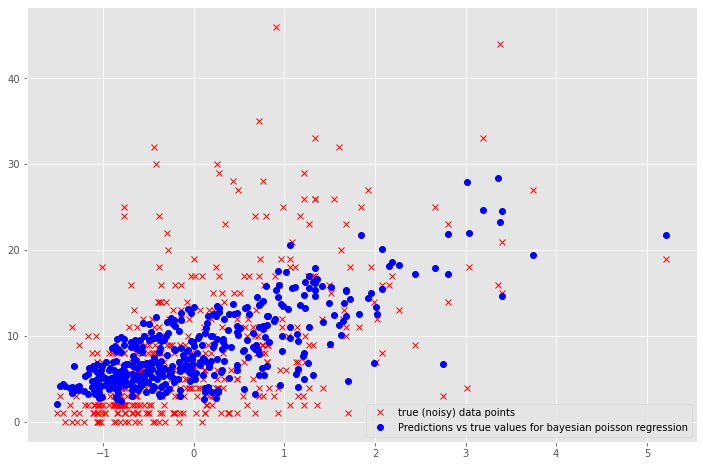

In [ ]:
plot_scatter(X_test,y_test,y_pred_nb, "Predictions vs true values for bayesian poisson regression")

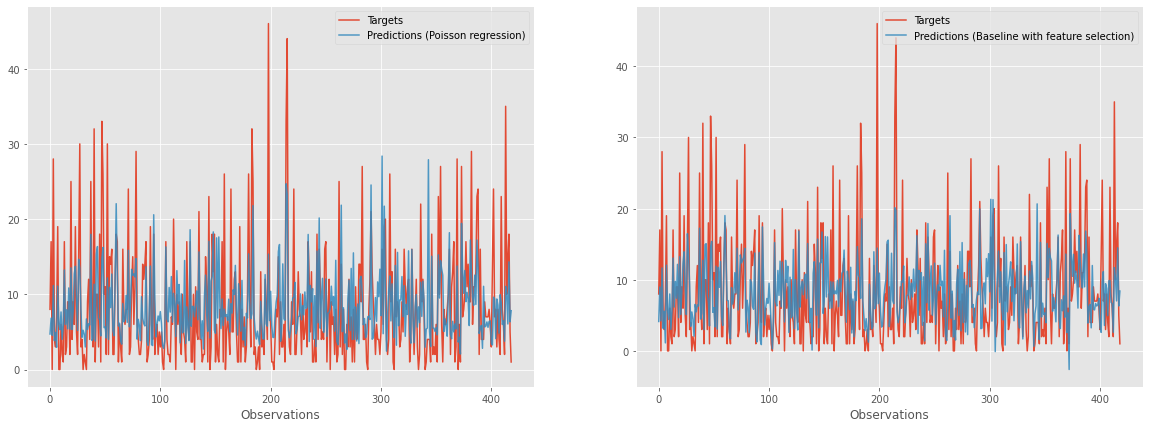

In [ ]:
# Visualize predictions from the hierarchical model and linear regression
plot_predictions_comp(y_test,y_pred_nb,"Predictions (Poisson regression)",y_pred_lreg_fs, "Predictions (Baseline with feature selection)")


As can be seen the mode 


## Neural network with poisson distribution
After having investigated different regression models that all assume a linear relationship between the target variable and the predictive features, it could be interesting to inccopperate a nonlinear component that does not exclusively assume linearity. This is to investigate if there are some non linear dependencies in the data.

In order to inccoperate a nonlinear term a neural network is implemented, that adds the non linear term through a neural network. 

As proposed in the lectures, we have split the features into $X_n'$ and $X_n^*$ such that the union is $X_n$. One set of the features will be modelled with a linear relationship between the variables (these features will be the selected features), while the other $X_n^*$ would undergo a non-linear transformation thorugh a neural network and thus operate as the non linear term. 

This will be passed through the poisson distirbution as posterior predictive - in that way incoperating the poisson regresison and anon lienar term thorugh the neural network.

$$
y~poisson(\alpha + X'\beta + f_{nnet}(X*_n)+\phi_n)
$$



The structure for the neural network was found to be best performing.

STRUKTUR

The PGM can be seen as follows



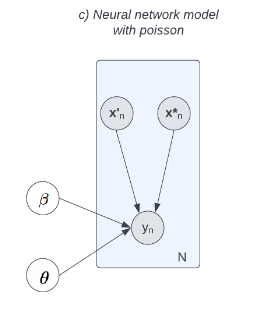

In [11]:
Image('Images/n_poisson.png')

The generative process is as follows

After the architecture is made, based on the strucutre visuliased above. 

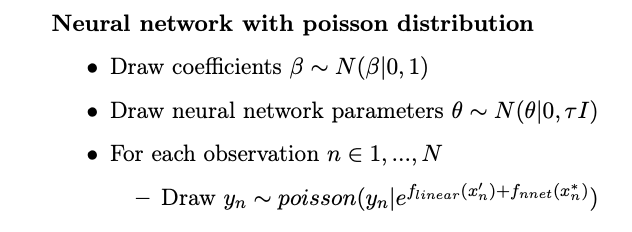

In [13]:
Image('Images/h_n_poisson.png')

In [ ]:
# Create architecture
from torch import nn, Tensor
import torch.optim as optim
from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam

class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden1)
        self.h1_layer = torch.nn.Linear(n_hidden1, n_hidden2)
        self.h2_layer = torch.nn.Linear(n_hidden2, n_hidden2)
        self.out_layer = torch.nn.Linear(n_hidden2, n_out)
        
        # Activation functions
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        # Forward pass
        X = self.relu(self.in_layer(X))
        X = self.relu(self.h1_layer(X))
        X = self.relu(self.h2_layer(X))
        X = self.out_layer(X)
        
        return X


Using the architecture we can now add the priors in the neural network on its weights and create the neural network model,

In [ ]:

def nnet_interpretable_model(X, y=None):
    
    
    X_linear = X[:, feature_ids]
    X_nonlinear = X[:, [i for i in range(X.shape[1]) if i not in feature_ids]]
    
    tau = 1
    N, input_dim_non = X_nonlinear.shape
    N, input_dim = X_linear.shape
    
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X_nonlinear.shape[1], n_hidden1=7,n_hidden2=3, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(0, 1))                    # Prior for the coefficients
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    
    
    # The generative process
    with pyro.plate("observations"):
        linear_out = torch.sum(alpha + X_linear*beta_lin,axis=1)
        nn_out = sampled_model(X_nonlinear).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
        y = pyro.sample("obs", dist.Poisson(torch.exp(linear_out + nn_out)), obs=y)

        
    return y

    

After having created the neural network model, the next step is to preprocess the data

In [ ]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train = torch.tensor(X_train_std).float()
X_test = torch.tensor(X_test_std).float()

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  


After having preprocessed data, we can now run the model. 

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 22991.9
[500] ELBO: 6922.8
[1000] ELBO: 6631.6
[1500] ELBO: 6432.4
[2000] ELBO: 6326.4
[2500] ELBO: 6329.3
[3000] ELBO: 6206.7
[3500] ELBO: 6231.1
[4000] ELBO: 6207.9
[4500] ELBO: 6227.5
[5000] ELBO: 6180.1
[5500] ELBO: 6167.1
[6000] ELBO: 6184.3
[6500] ELBO: 6118.0
[7000] ELBO: 6203.7
[7500] ELBO: 6129.8
[8000] ELBO: 6118.6
[8500] ELBO: 6186.1
[9000] ELBO: 6185.5
[9500] ELBO: 6346.3


Again we will extract the latent variables through the posterior predictive.

In [ ]:
# Get posterior samples for beta
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_train, y_train)

The mean estimated beta can be seen below

In [ ]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Estimated beta: 0.07703554


Next we can make the predictive on the test using the model 

In [ ]:
# Make predictions for test set
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))

samples = predictive(X_test)
y_pred_neural = samples["obs"].mean(axis=0).detach().numpy()

#mae = np.mean(np.abs(y_test - y_pred_neural))
#print("MAE:", mae)

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_pred_neural)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.537
MAE: 5.186
RMSE: 6.986
MSE: 48.808
R2: 0.207


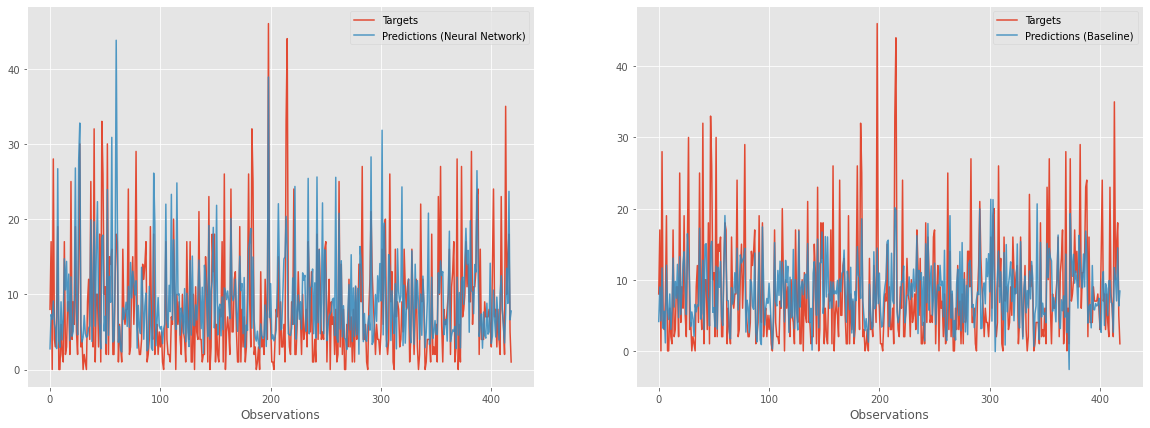

In [ ]:
plot_predictions_comp(y_test,y_pred_neural,"Predictions (Neural Network)",y_pred_lreg_fs, "Predictions (Baseline)")

From the figures it can be seen that in contratory to the other models this model predict a bit too high, while the other models predict lower. 
The performance has worsened compared to the opission regression without the nonlinear term, which indicate that the data do not have a non linear dependency. 

## Neural network with NB distribution

As with the poission distirbution it is now investigated if the NB regression will perfom better with a non linear term.

PGM and generative process can be seen below

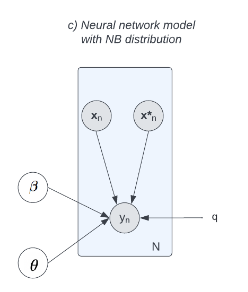

In [17]:
Image('Images/n_NB.png')

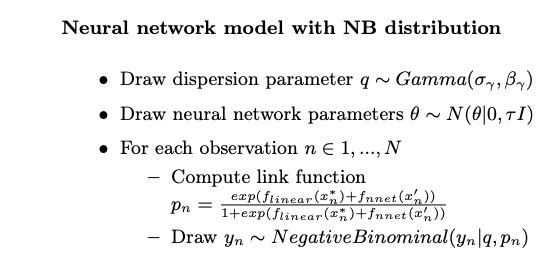

In [16]:
Image('Images/g_n_NB.png')

**Note: the code is not able to run due to an error that we were not able to resolve unfortunately. The code however shows the idea behind the model.**

In [ ]:
def nnet_interpretable_model_gamma(X, y=None):
    
    X_linear = X[:, feature_ids_shifted]
    X_nonlinear = X[:, [i for i in range(X.shape[1]) if i not in feature_ids_shifted]]
    
    tau = 1
    N, input_dim_non = X_nonlinear.shape
    N, input_dim = X_linear.shape
    
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X_nonlinear.shape[1], n_hidden1=7,n_hidden2=3, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    
    # parameters
    alpha_gamma = 2
    beta_gamma = 4 
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(0, 1))                    # Prior for the coefficients
    #alpha = pyro.sample("alpha", dist.Normal(0,1))                   # Prior for the bias/intercept
    
    q = pyro.sample("q", dist.Gamma(alpha_gamma, beta_gamma))               
    q = torch.exp(q)
    
    # The generative process
    with pyro.plate("observations"):
        linear_out = torch.sum(X_linear*beta_lin,axis=1)
        nn_out = sampled_model(X_nonlinear).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
        #link function
        psi_mu = linear_out+nn_out
        p_i = torch.exp(psi_mu)/(1+torch.exp(psi_mu))
        
        y = pyro.sample("obs", dist.NegativeBinomial(q,probs=p_i), obs=y)
            
    return y

    

In [ ]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std = torch.tensor(X_train_std).float()
X_test_std = torch.tensor(X_test_std).float()

# X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
# X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
# cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# # mangler at add intercept
X_train_std = torch.cat((torch.ones(X_train_std.shape[0], 1), X_train_std), dim=-1)
X_test_std = torch.cat((torch.ones(X_test_std.shape[0], 1), X_test_std), dim=-1)  


In [ ]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model_gamma)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model_gamma, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 11352.1
[500] ELBO: 5348.9
[1000] ELBO: 5141.3
[1500] ELBO: 5108.7
[2000] ELBO: 5091.8
[2500] ELBO: 5088.5
[3000] ELBO: 5218.2
[3500] ELBO: 5078.6
[4000] ELBO: 5095.8
[4500] ELBO: 5088.5
[5000] ELBO: 5095.0
[5500] ELBO: 5083.1
[6000] ELBO: 5088.0
[6500] ELBO: 5105.7
[7000] ELBO: 5143.6
[7500] ELBO: 5092.4
[8000] ELBO: 5090.0
[8500] ELBO: 5076.1
[9000] ELBO: 5093.6
[9500] ELBO: 5122.1


In [ ]:
# Get posterior samples for beta
predictive = Predictive(nnet_interpretable_model_gamma, guide=guide, num_samples=1000,
                        return_sites=("q","beta",))
samples = predictive(X_train_std, y_train)

In [ ]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Estimated beta: 0.12280758


In [ ]:
# Make predictions for test set
predictive = Predictive(nnet_interpretable_model_gamma, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test_std)

y_pred_neural_gamma = samples["obs"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_pred_neural_gamma)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

In [ ]:
plot_predictions_comp(y_test,y_pred_neural_gamma,"Predictions (Neural Network)",y_pred_lreg_fs, "Predictions (Baseline)")

# Bayesian hierarchical modelling

As it was evident in the exploratory analysis that data might be somewhat related in terms of county the data is investigated further using a hierachical model. This is done in order to examine if data are distributed dependent on some underlying patterns that can help us in our prediction model. 

The shared hyper prior will be the feature "County" that groups each observation into a county Bronx, New york, Kings, Queens or richmond. This shared hyper prior allows our models to share the individual properties of the observations among counties. In this way the hierarchical model is an intermediate solution where the degree of pooling is determined by the data and a prior on the amount of pooling.

The followin section implements 4 different hierarchical models based on the same distributions as our regression models, in order to compare and examine if the hierarchical strcture can help our regression models to perform better. 

The picture below is from the exploratory analysis that showshow the number of accidents among youth pedestrians are distributed in the different counties

## Hierarchical modelling with poisson as posterior predictive
In this section the  baysian hierarchical model is based upon the poisson regression model.

The PGM is as follows:



In [ ]:
Image('Images/h_poisson.png')

The generative process is as follows


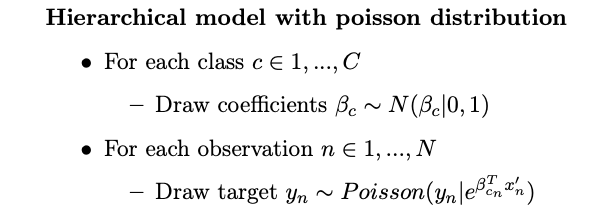

In [18]:
Image('Images/g_h_poisson.png')

The code below implements the hierarchical poisson model. For each county a shared hyperprior beta is made that is used in poisson regression made for each observation.

In [ ]:
def hierarchical_model_pois(X ,cat, n_cat, obs=None):
    """_Hierarchical with poisson distribution
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Set hyper parameters 
    sigma_beta = 1
    mu_beta = 0
    
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        
        beta = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        # create link function  
        psi = torch.sum(X*beta[cat], axis = 1) 
        
        #sample prediction
        y = pyro.sample("y", dist.Poisson(torch.exp(psi)), obs=obs)
        
    return y

Next step the data is preprocessed accordingly. Again the standardised X set is used. 

In [ ]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()# these are indices, therefore they need to be (long) integers
cat_test = torch.tensor(cat_test).long()

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  


After ahving preprocessed the data, the model is run

In [ ]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model_pois)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model_pois, guide, optimizer, loss=elbo)

# hierarchical_model(X ,cat, n_cat, n_ind, ind, obs=None)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, cat_train, n_cat, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 24076.9
[500] ELBO: 6390.9
[1000] ELBO: 6268.0
[1500] ELBO: 6273.0
[2000] ELBO: 6288.2
[2500] ELBO: 6265.9
[3000] ELBO: 6251.8
[3500] ELBO: 6272.4
[4000] ELBO: 6278.8
[4500] ELBO: 6262.5
[5000] ELBO: 6258.9
[5500] ELBO: 6282.2
[6000] ELBO: 6270.5
[6500] ELBO: 6260.5
[7000] ELBO: 6259.4
[7500] ELBO: 6257.1
[8000] ELBO: 6270.3
[8500] ELBO: 6276.5
[9000] ELBO: 6270.5
[9500] ELBO: 6276.9
Wall time: 1min 13s


Now it is possible to predict with the model and thereafter extract the posterior samples for the latent vairables using the puro class predictive. 
The extracted latent vairbales is
* beta

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model_pois, guide=guide, num_samples=4000,
                        return_sites=("beta"))

samples = predictive(X_train_std_fs[:,:], cat_train, n_cat, y_train)

beta_samples_hp = samples["beta"].detach().numpy()

In order to see how the vairables behave the intercept and the featuredistirbution for each county is visualised. 

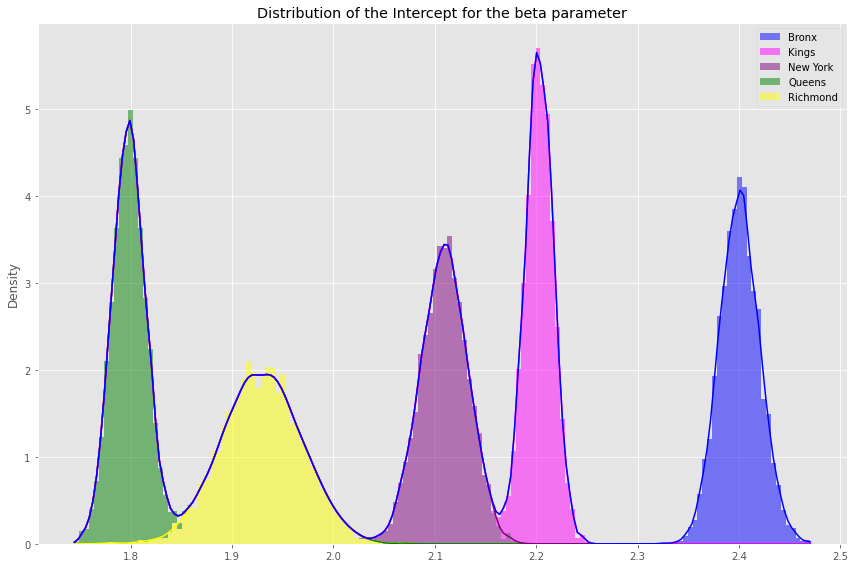

In [ ]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

# create dataframe and set columns for the relevant counties
df = pd.DataFrame(beta_samples_hp[:,:,0])
df.columns = [cat_string[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette)
plt.title(f"Distribution of the Intercept for the beta parameter")
fig.tight_layout()
#fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
plt.show()

Compared to the previous visualisation this model is able to seperate the categories way better. This indicates that there are somewhat clusters that the poisson hierarchical model are able to use. 

From the visualisation it can be seen that Richmond has a quite large stadardeviaion while the other counties has a smaller standard deviation. It seems as Bronx and Kings are more prone to having more accidents compared to queens that is to the outer left. (?)


To get a better interpretation of how the features effect the predictions in the different counties following figures are visualised. 

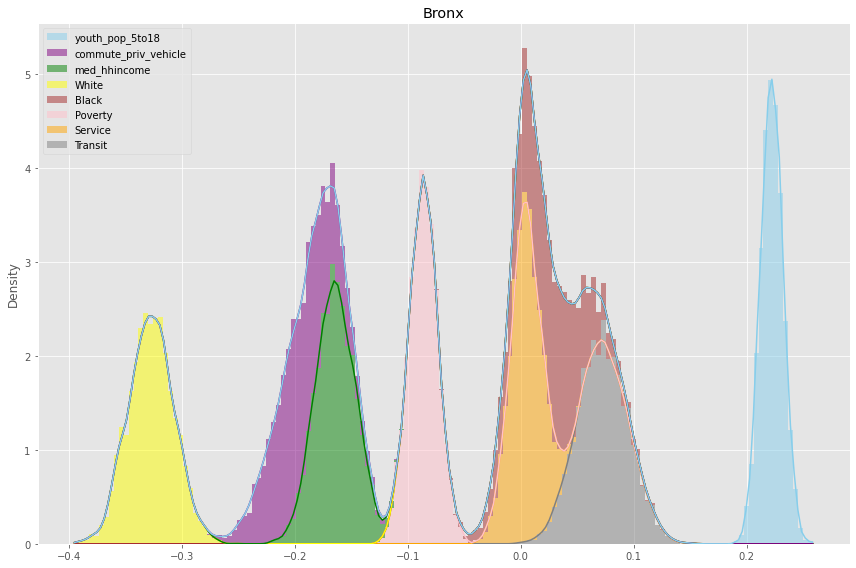

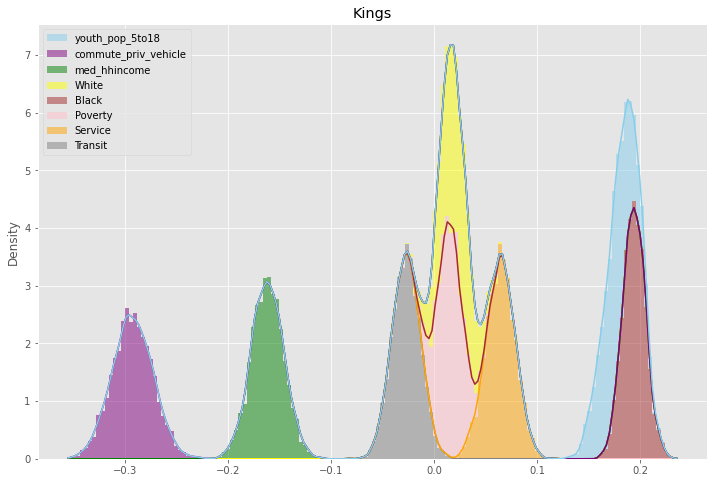

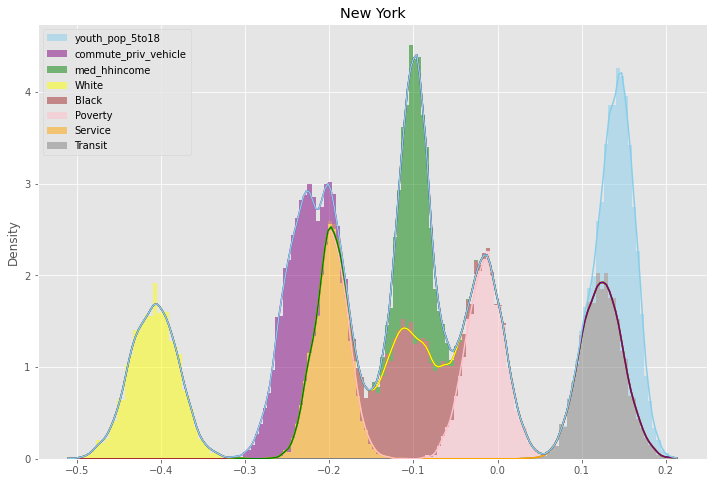

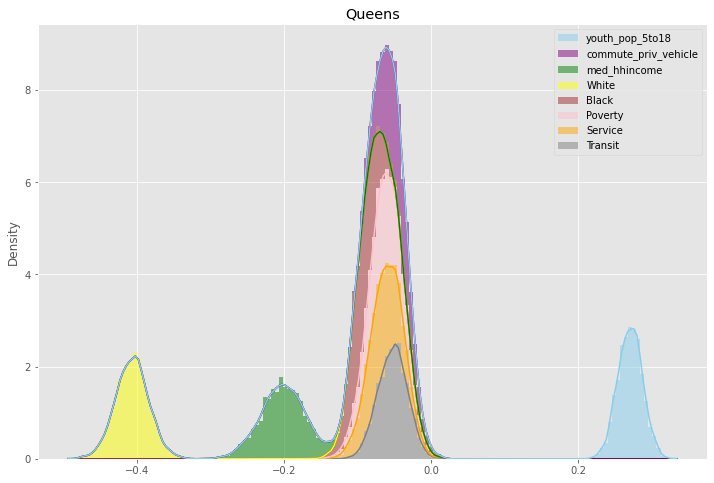

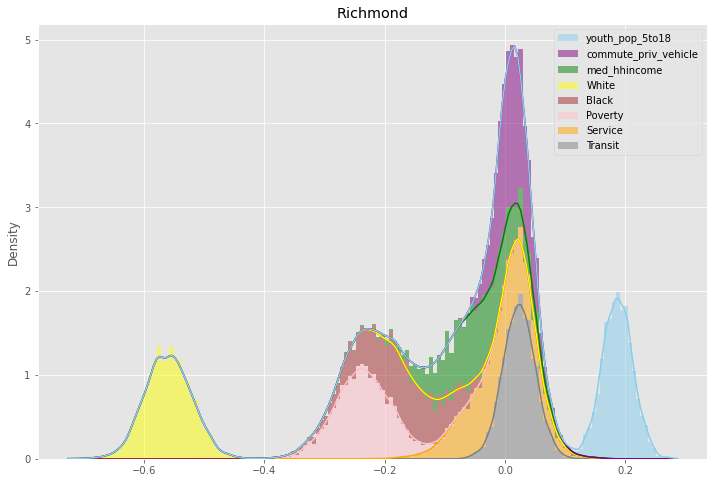

In [ ]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette2 = {
    #"intercept" : 'blue',
    "youth_pop_5to18" : 'skyblue',
    "commute_priv_vehicle" : 'purple',
    "med_hhincome" : 'green',
    "White" : 'yellow',
    "Black" : 'brown',
    "Poverty" : "pink",
    "Service" : "orange",
    "Transit" : "grey"
    
}


for i in range(len(cat_string)):
    # create dataframe and set columns for the relevant counties
    df = pd.DataFrame(beta_samples_hp[:,i,1:])
    df.columns = [feat_reduction]
    sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette2,
                line_kws= {'color':'grey'})
    plt.title(f""+cat_string[i])
    fig.tight_layout()
    #fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
    plt.show()

From the figures it can be seen that a general tendency is that the youth population has a postive effect on the predictions, meaning the mlarger the yout population the more likely that an accident occurs according to the model.  
Moreover it seems as the feature "transit" also indicated the higher transit for an observation, the more likely that an accident occur. 

An interesting finding is that the model suggest that if you are white, the less likely you are to be in an accident, whereas if you are black living in Kings you are more prone to occur an accident. 

Queens seem to find it difficult to seperate some of the features as the most of them are untop of eachother.

### Predictions with the hierarchical model
Using the expected values of beta and q from the posterior samples it is possible to make predictions on the test set, to actually see how well the model performs. 

In [ ]:
# Predict by computing the mean of parameters and pass through poisson
beta_hat = np.mean(beta_samples_hp, axis=0)
psi = np.sum(beta_hat[cat_test] * X_test_std_fs[:, :].numpy(), axis=1)
Pois_d = dist.Poisson(torch.tensor(np.exp(psi)))
y_hat_hpois = np.array(Pois_d.mean) # Extract mean from Poisson dist and use as prediction

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat_hpois)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.569
MAE: 4.389
RMSE: 6.357
MSE: 40.410
R2: 0.314


In [ ]:
# Make predictions for test set
predictive = Predictive(hierarchical_model_pois, guide=guide, num_samples=1000,
                        return_sites=("y", "_RETURN"))

samples = predictive(X_test_std_fs, cat_test, n_cat)
y_pred_nb = samples["y"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, mse, r2 = compute_error(y_true, y_pred_nb)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.582
MAE: 4.671
RMSE: 6.381
MSE: 40.715
R2: 0.338


As can be seen the bayesian hierarchical model based on a poisson regression performs way better than the hierarchical model with NB. However the model has not improved when comparing to the baseline. 

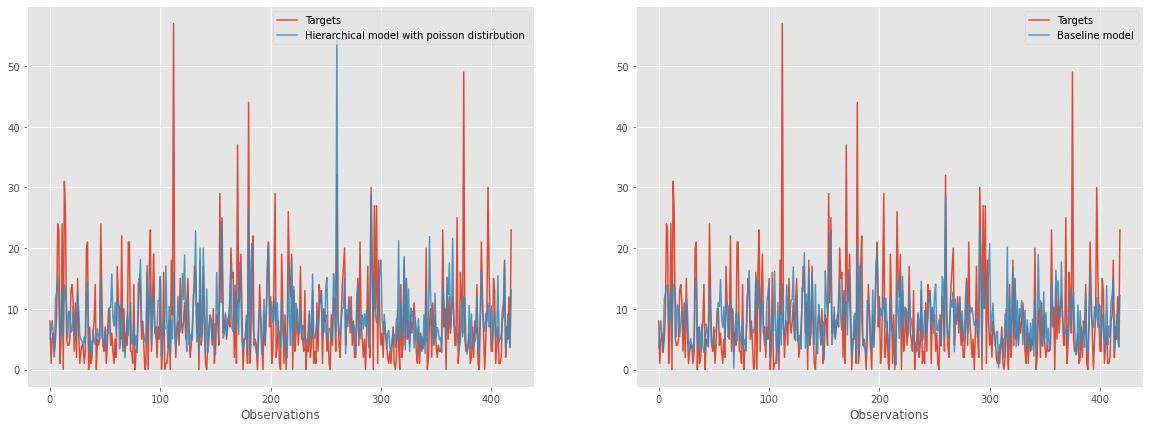

In [ ]:
plot_predictions_comp(y_test,y_hat_hpois,"Hierarchical model with poisson distirbution",y_pred_lreg_fs,"Baseline model")

These figures idicated that the bayesian hierahical model predict alot like the baseline model. 

## Baysian hierarchical model with NB as posterior predictive
The first baysian hierarchical model is based upon the regression model that uses gamma as conjungate prior and the negative binomial distribution as posterior predictive. 

The PGM is as follows:

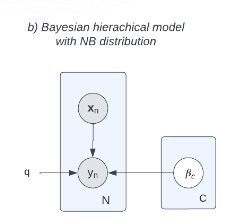

In [19]:
Image('Images/h_NB.png')

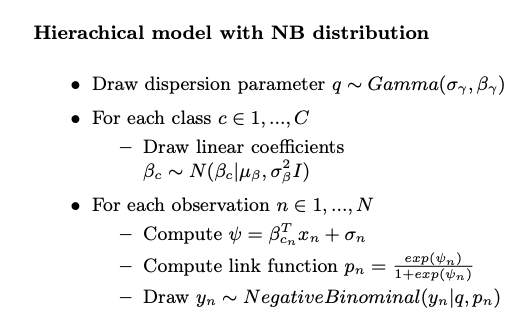

In [20]:
Image('Images/g_h_NB.png')

The generative process is as follows
image.png



Below the code for the hierarchical model is implemented

In [39]:
def hierarchical_model(X ,cat, n_cat, obs=None):
    """_Hierarchical with gamma distribution as conjungate prior distribution to poisson with hyper parameters alpha and beta. 
        Using negative binomial as posterior predictive_
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Draw parameters 
    alpha_gamma = 2
    beta_gamma = 6
    
    sigma_beta = 1
    mu_beta = 0
    
    # Draw priors
    # gamma distirbution
    q = pyro.sample("q", dist.Gamma(alpha_gamma, beta_gamma))
    #non-negative rate
    q = torch.exp(q)
    
    
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        
        beta = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        sigma = pyro.sample(
            "sigma",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        # create link function         
        psi_mu = torch.sum(X*beta[cat] +sigma[cat], axis = 1) 
        p_i = torch.exp(psi_mu)/(1+torch.exp(psi_mu))
        
        # Sample prediction using negative binomial on gamma prior as posterior predictive disitrbution (wiki)
        y = pyro.sample("y", 
                        dist.NegativeBinomial(q,probs=p_i), 
                        obs=obs) 
        
    return y

Next the data is preprocessed such that it is ready for the model. The data used in the model is the standardised X train and test set. 

In [136]:
#feature_ids_shifted = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()

# X_train_std_fs = torch.tensor(X_train[:,feature_ids]).float()
# X_test_std_fs = torch.tensor(X_test[:,feature_ids]).float()

y_train = torch.tensor(y_train).float()
y_train_std = torch.tensor(y_train_std).float()
#y_test_std = torch.tensor(y_test_std).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  


After having preprocessed the data the model is run

In [130]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# hierarchical_model(X ,cat, n_cat, n_ind, ind, obs=None)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, cat_train, n_cat, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 17953.0
[500] ELBO: 5202.8
[1000] ELBO: 5163.3
[1500] ELBO: 5191.9
[2000] ELBO: 5182.4
[2500] ELBO: 5167.1
[3000] ELBO: 5173.1
[3500] ELBO: 5152.0
[4000] ELBO: 5171.3
[4500] ELBO: 5151.3
[5000] ELBO: 5170.0
[5500] ELBO: 5169.7
[6000] ELBO: 5166.7
[6500] ELBO: 5168.4
[7000] ELBO: 5180.2
[7500] ELBO: 5169.6
[8000] ELBO: 5156.6
[8500] ELBO: 5173.7
[9000] ELBO: 5164.2
[9500] ELBO: 5156.8
Wall time: 2min 28s


Next we can make our predictions are extract the posterior samples for the latent vairables. This is done using the pyro class predictive.
We are extracting follwoing latent variables
* beta parameter
* q - NB parameter

In [137]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=4000,
                        return_sites=("beta", "q"))

samples = predictive(X_train_std_fs[:,:], cat_train, n_cat, y_train)

beta_samples = samples["beta"].detach().numpy()
gamma_q_samples = samples["q"].detach().numpy()

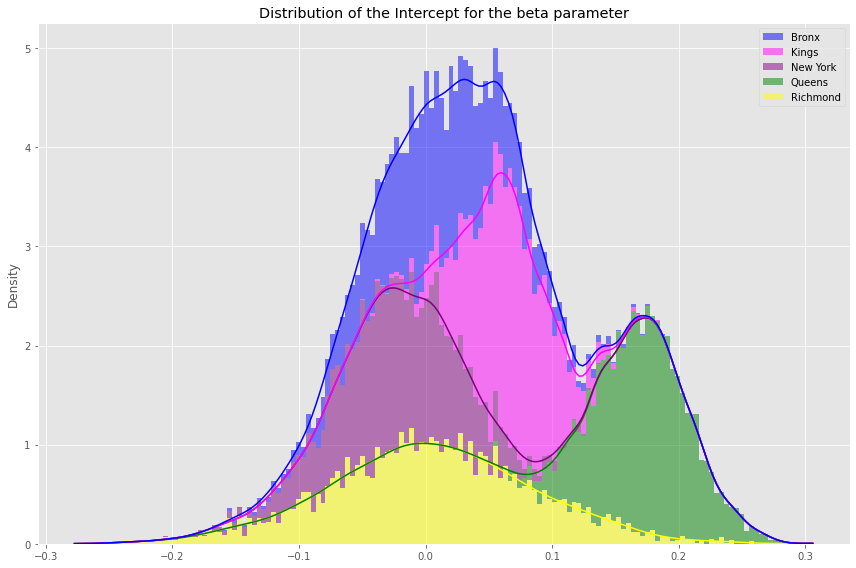

In [139]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

# create dataframe and set columns for the relevant counties
df = pd.DataFrame(beta_samples[:,:,0])
df.columns = [cat_string[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette)
plt.title(f"Distribution of the Intercept for the beta parameter")
fig.tight_layout()
#fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
plt.show()

The figure above shows the distribution betewen the differnet counties - as it can seen - the data is not seperated that well in the different group levels. 

### Predictions with the hierarchical model
Using the expected values of beta and q from the posterior samples we can make our predictions on the test set.

In [140]:
# Predict by computing the mean of parameters and passing through NB dist
beta_hat = np.mean(beta_samples, axis=0)
q_hat = np.mean(gamma_q_samples, axis=0)
#alpha_hat = np.mean(alpha_samples, axis=0)

psi = np.sum(beta_hat[cat_test] * X_test_std_fs[:, :].numpy(), axis=1)
p_i = torch.exp(torch.tensor(psi))/(1+torch.exp(torch.tensor(psi)))
NB_d = dist.NegativeBinomial(torch.tensor(q_hat), probs=torch.tensor(p_i))
y_hat_mean = np.array(NB_d.mean) # Extract mean from NB dist and use as prediction


corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.561
MAE: 7.072
RMSE: 9.917
MSE: 98.351
R2: 0.000


Exclusively looking at the different performance metrics it can be seen that the predictions has worsened compared to the baseline. This it either an indication that this model is not a good fit for this dataset and the hierarchical struture were not able to improve compared to the baseline. 

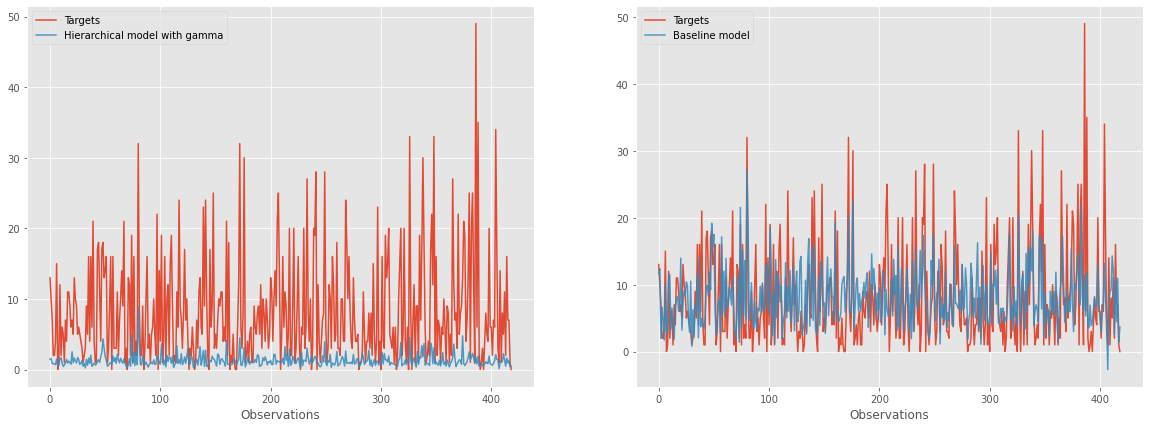

In [141]:
plot_predictions_comp(y_test,y_hat_mean,"Hierarchical model with gamma",y_pred_lreg_fs,"Baseline model")

The figure above does also indicate that the model do not predict that good and the prediction variables made with the hierarchical model flutuated around 0 while the the targets fluctuated around 10 wioth some high outliers. 

Compared to the baseline the baseline performs the best. 

Though, next it is investiagted if another type of hierarchical model is better to predict the target varaible. 

# <span style="color:red">Hierachical model with poisson and neural net
</span>

It could be interesting to extend the hierarchical model to include non-linerity and thus create a model in combination of the poission regression, the non lienar term through a neural network and the hierarchical model. 

As proposed in the lectures, we have split the features into $X_n'$ and $X_n^*$ such that the union is $X_n$. One set of the features will be modelled with a linear relationship between the variables (these features will be the selected features), while the other $X_n^*$ would undergo a non-linear transformation thorugh a neural network and thus operate as the non linear term. 
At last this will be predicted using a poisson distribution. 

The PGM can be seen below



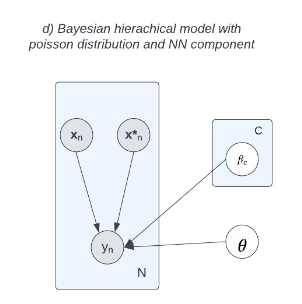

In [22]:
Image('Images/hn_poisson.png')

The generative process can be seen below

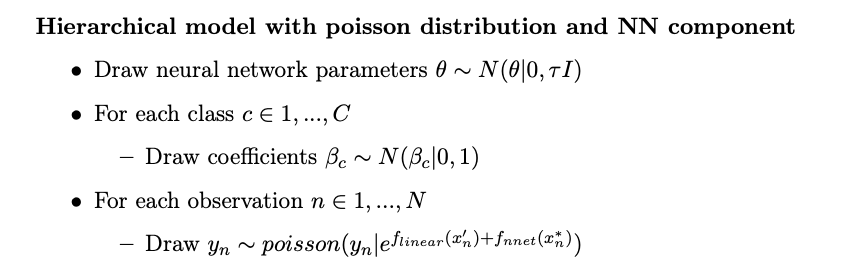

In [23]:
Image('Images/g_hn_poisson.png')

**Note: the code is not able to run due to an error that we were not able to resolve unfortunately. The code however shows the idea behind the model.**

In [229]:
def hierarchical_model_nn_pois(X ,cat, n_cat, obs=None):
    """_Hierarchical with poisson distribution
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    X_linear = X[:, feature_ids]
    X_nonlinear = X[:, [i for i in range(X.shape[1]) if i not in feature_ids]]
    
    N, input_dim = X_linear.shape

    # Initialize the neural network from PyTorch 
    #torch_model = FFNN(n_in=X_nonlin.shape[1], n_hidden1=7,n_hidden2=3, n_out=1) 
    torch_model = FFNN(n_in=X_nonlinear.shape[1], n_hidden=8, n_out=1) 
    
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), 
                                   torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model    
    
    # Set parameters 
    sigma_beta = 1
    mu_beta = 0
    
    
    #neural component
    nn_out = sampled_model(X_nonlinear).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        # Draw linear coefficient parameters for each group
        beta_lin = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        alpha = pyro.sample(
            "alpha",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        #linear output
        linear_out = torch.sum(X_linear*beta_lin[cat],axis=1)
        #neural network component 
        nn_out = sampled_model(X_nonlinear).squeeze(-1) # Feed-forward the design matrix X through the neural network , remainng columns
    
        #sample prediction
        y = pyro.sample("y", dist.Poisson(torch.exp(nn_out + linear_out)), obs=obs)
    
    return y


In [73]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std = torch.tensor(X_train_std).float()
X_test_std = torch.tensor(X_test_std).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
#X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
#X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  

In [67]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model_nn_pois)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model_nn_pois, guide, optimizer, loss=elbo)

#hierarchical_model(X ,cat, n_cat, n_ind, ind, obs=None)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std, cat_train, n_cat,feature_ids, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 28949.7
[500] ELBO: 6969.0
[1000] ELBO: 6453.2
[1500] ELBO: 6328.2
[2000] ELBO: 6325.3
[2500] ELBO: 6208.1
[3000] ELBO: 6239.2
[3500] ELBO: 6215.7
[4000] ELBO: 6211.3
[4500] ELBO: 6227.5
[5000] ELBO: 6225.1
[5500] ELBO: 6191.6
[6000] ELBO: 6235.2
[6500] ELBO: 6195.7
[7000] ELBO: 6235.4
[7500] ELBO: 6236.4
[8000] ELBO: 6192.0
[8500] ELBO: 6310.1
[9000] ELBO: 6158.5
[9500] ELBO: 6301.2
Wall time: 4min 29s


Extract the posterior samples for the latent vairables using the puro class

In [68]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model_nn_pois, guide=guide, num_samples=4000,
                        return_sites=("beta", "y",))
samples = predictive(X_train_std, cat_train, n_cat, feature_ids, y_train)

In [69]:
# plot the posterior distirbution of the parameters
beta_samples = samples["beta"].detach().numpy()

In [26]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

# create dataframe and set columns for the relevant counties
df = pd.DataFrame(alpha_samples[:,:,0])
df.columns = [cat_string[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette)
plt.title(f"Distribution of the Intercept for the beta parameter")
fig.tight_layout()
#fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
plt.show()

### Predictions with the hierarchical model
Using the expected values of beta and q from the posterior samples

In [74]:
X_test_std.shape

torch.Size([419, 38])

In [27]:
predictive = Predictive(nnet_interpretable_model_gamma, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))

samples = predictive(X_test_std)

y_pred_hier_neural_gamma = samples["obs"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_pred_hier_neural_gamma)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

# <span style="color:red">Hierachical model with NB and neural net
</span>

The PGM and the generative process can be seen below

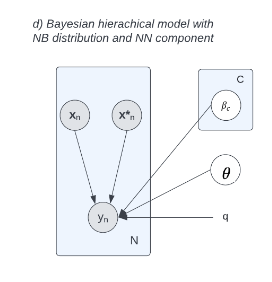

In [24]:
Image('Images/hn_NB.png')

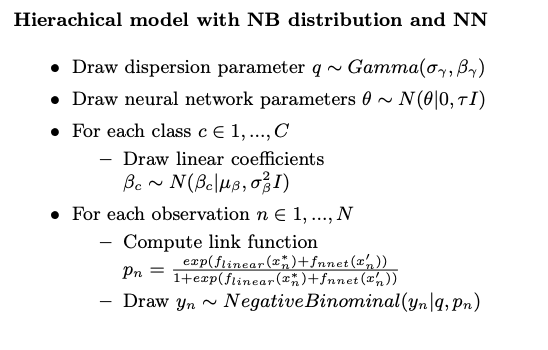

In [25]:
Image('Images/g_hn_NB.png')

**Note: the code is not able to run due to an error that we were not able to resolve unfortunately. The code however shows the idea behind the model.**

In [229]:
def hierarchical_model_nn_pois(X ,cat, n_cat, obs=None):
    """_Hierarchical with poisson distribution
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    X_linear = X[:, feature_ids]
    X_nonlinear = X[:, [i for i in range(X.shape[1]) if i not in feature_ids]]
    
    N, input_dim = X_linear.shape

    # Initialize the neural network from PyTorch 
    #torch_model = FFNN(n_in=X_nonlin.shape[1], n_hidden1=7,n_hidden2=3, n_out=1) 
    torch_model = FFNN(n_in=X_nonlinear.shape[1], n_hidden=8, n_out=1) 
    
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), 
                                   torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model    
    
    # Set parameters 
    sigma_beta = 1
    mu_beta = 0
    
    # Draw priors
    # gamma distirbution
    q = pyro.sample("q", dist.Gamma(alpha_gamma, beta_gamma))
    #non-negative rate
    q = torch.exp(q)
    
    #neural component
    nn_out = sampled_model(X_nonlinear).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        # Draw linear coefficient parameters for each group
        beta_lin = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        alpha = pyro.sample(
            "alpha",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        #linear output
        linear_out = torch.sum(X_linear*beta_lin[cat],axis=1)
        
        #neural network component 
        nn_out = sampled_model(X_nonlinear).squeeze(-1) # Feed-forward the design matrix X through the neural network , remainng columns
    
        #link function
        p_i = torch.exp(linear_out+nn_out)/(1+torch.exp(linear_out+nn_out))
        
        # Sample prediction using negative binomial on gamma prior as posterior predictive disitrbution (wiki)
        y = pyro.sample("y", dist.NegativeBinomial(q,probs=p_i), obs=obs) 
    
    return y
